In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import csv

In [3]:
#import lung ppi 
data = pd.read_csv("./project_hpa_protein_data/lung.tsv", delimiter = '\t', header = None, usecols = [0,1])
data

,0,1
0,ENSG00000105483,ENSG00000171467
1,ENSG00000100030,ENSG00000261371
2,ENSG00000162385,ENSG00000169045
3,ENSG00000141458,ENSG00000184584
4,ENSG00000117724,ENSG00000197321
...,...,...
102367,ENSG00000138131,ENSG00000138190
102368,ENSG00000107581,ENSG00000135480
102369,ENSG00000094631,ENSG00000239713
102370,ENSG00000167900,ENSG00000196705


In [4]:
#create ppi graph 
G = nx.from_pandas_edgelist(data, source = 0, target = 1)
nx.is_directed(G)

False

In [5]:
#import krogan proteins list
krogan_proteins = pd.read_excel("./krogan_proteins.xlsx", usecols= [0,1])
krogan_proteins

,Gene stable ID,Gene name
0,ENSG00000280759,AP2A2
1,ENSG00000228691,NEU1
2,ENSG00000282003,TUBGCP3
3,ENSG00000224774,CSNK2B
4,ENSG00000282230,ADAM9
...,...,...
327,ENSG00000198933,TBKBP1
328,ENSG00000136485,DCAF7
329,ENSG00000154240,CEP112
330,ENSG00000109062,SLC9A3R1


### Creating network diffusion visualization

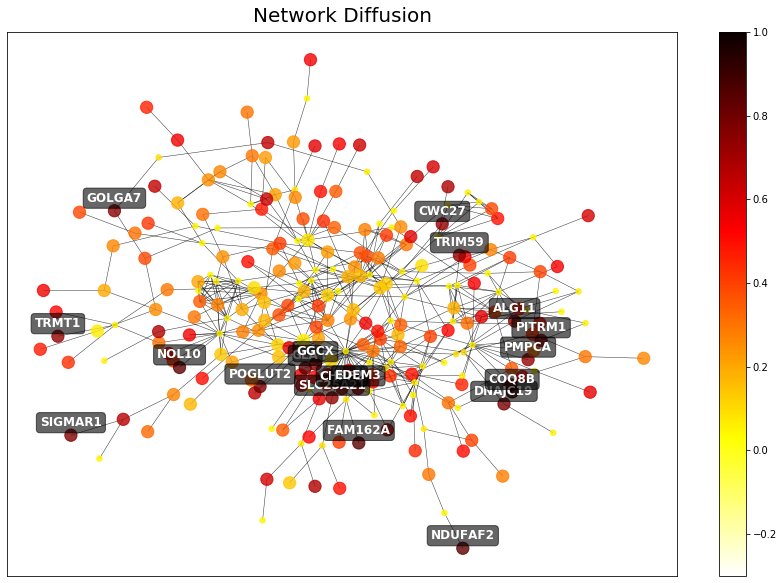

In [6]:
#importing diffusion data for nodes with diffusion score > 0.005
diffdata = pd.read_csv("./diffusion_threshold005.csv", index_col=0)

diffdict = diffdata.to_dict(orient='index')

nx.set_node_attributes(G, diffdict)
G.nodes(data = True)

subnodes = list(diffdata.index)
H = G.subgraph(subnodes)
H1 = G.subgraph(max(nx.connected_components(H), key=len))

valuedict = diffdata['diffusion_value'].to_dict()
labels = {}
for key,value in valuedict.items():
    if key in H1.nodes():
        if value > 0.7:
            labels[key] = krogan_proteins.loc[krogan_proteins['Gene stable ID'] == key, 'Gene name'].iloc[0]

#setting values for colors
values = [valuedict.get(node, 0.0049) for node in H1.nodes()]

#setting sizeof krogan proteins to be larger
sizes = [150 if node in list(krogan_proteins['Gene stable ID']) else 30 for node in H1.nodes()]

import matplotlib.pyplot as plt
import matplotlib as mpl

pos = nx.layout.kamada_kawai_layout(H1)
pos_higher = {}
y_off = 0.05 # offset on the y axis

for k, v in pos.items():
    pos_higher[k] = (v[0], v[1]+y_off)


plt.figure(figsize=(15,10))
plt.title("Network Diffusion", pad = 10, fontdict = {'fontsize': 20})
nx.draw_networkx(H1, pos, cmap=plt.get_cmap('hot_r'), node_color=values, node_size = sizes, width = 0.5, with_labels = False , vmin = -0.3, vmax =1, alpha = 0.8)
nx.draw_networkx_labels(H1,pos_higher,labels,font_size=12,font_color='white', bbox = dict(boxstyle='round', facecolor='black', alpha=0.6), font_weight = 'bold')
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('hot_r'), norm=plt.Normalize(vmin = -0.3, vmax=1))
sm._A = values
plt.colorbar(sm)

plt.savefig("diffusion.png")

### Creating Random Walk with Restarts visualization

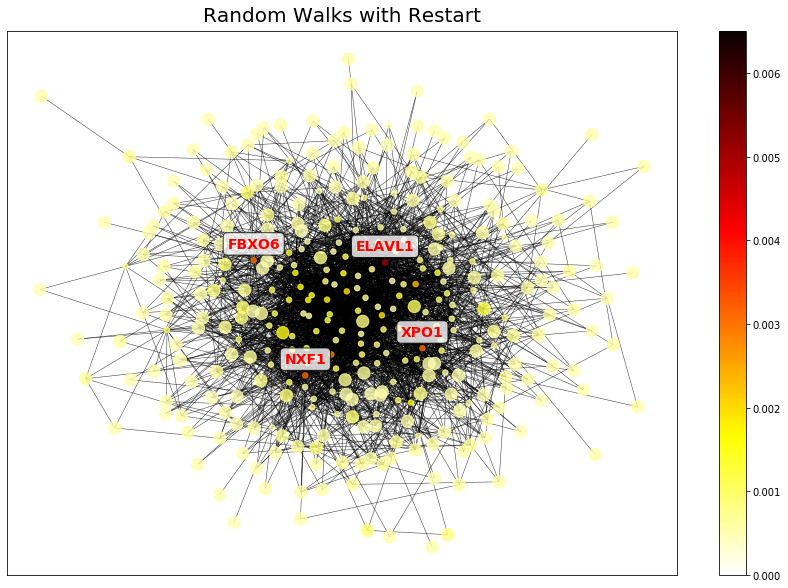

In [7]:
# importing rwr data for nodes with rwr score > 0.0005
rwrdata = pd.read_csv("./rwr_thresh0005.csv", index_col=0)

rwrdict = diffdata.to_dict(orient='index')

#print(rwrdata.describe())

nx.set_node_attributes(G, rwrdict)
G.nodes(data = True)

subnodes = list(rwrdata.index)
H = G.subgraph(subnodes)
H1 = G.subgraph(max(nx.connected_components(H), key=len))

valuedict = rwrdata['0'].to_dict()

# dictionary for the top 4 scoring rwr, manually converted ensembl id to gene symbol
labels = {'ENSG00000082898':'XPO1','ENSG00000162231':'NXF1','ENSG00000066044':'ELAVL1','ENSG00000116663':'FBXO6'}
# for key,value in valuedict.items():
#     if key in H.nodes():
#         if value > 0.003:
#             #labels[key] = krogan_proteins.loc[krogan_proteins['Gene stable ID'] == key, 'Gene name']
#             labels[key] = key

#values for node colors
values = [valuedict.get(node, 0.00049) for node in H.nodes()]

# setting size of krogan proteins to be larger
sizes = [150 if node in list(krogan_proteins['Gene stable ID']) else 30 for node in H.nodes()]

import matplotlib.pyplot as plt
import matplotlib as mpl

pos = nx.layout.kamada_kawai_layout(H)
pos_higher = {}
y_off = 0.06 # offset on the y axis

for k, v in pos.items():
    pos_higher[k] = (v[0], v[1]+y_off)


plt.figure(figsize=(15,10))
plt.title("Random Walks with Restart", pad = 10, fontdict = {'fontsize': 20})
nx.draw_networkx(H, pos, cmap=plt.get_cmap('hot_r'), node_color=values, node_size = sizes, width = 0.5, with_labels = False , vmin = 0, vmax=0.0065, alpha = 0.8)
nx.draw_networkx_labels(H,pos_higher,labels,font_size=14,font_color='r', bbox = dict(boxstyle='round', facecolor='white', alpha=0.8), font_weight ='bold')
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('hot_r'), norm=plt.Normalize(vmin = 0, vmax=0.0065))
sm._A = values
plt.colorbar(sm)

plt.savefig("rwr.png")